In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel("2025 Allianz Datathon Dataset.xlsx", sheet_name="Climate Data")

In [4]:
df.head()

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
0,71075,2010,1,1,NaN,NaN,NaN
1,71075,2010,1,2,NaN,NaN,NaN
2,71075,2010,1,3,NaN,NaN,NaN
3,71075,2010,1,4,NaN,NaN,NaN
4,71075,2010,1,5,NaN,NaN,NaN


# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39813 entries, 0 to 39812
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Bureau of Meteorology station number  39813 non-null  int64  
 1   Year                                  39813 non-null  int64  
 2   Month                                 39813 non-null  int64  
 3   Day                                   39813 non-null  int64  
 4   Maximum temperature (Degree C)        38275 non-null  float64
 5   Minimum temperature (Degree C)        38280 non-null  float64
 6   Rainfall amount (millimetres)         37857 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 2.1 MB


In [6]:
df.describe(include="all")

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres)
count,39813.000000,39813.000000,39813.000000,39813.000000,38275.000000,38280.000000,37857.000000
mean,78393.697536,2017.294075,6.429106,15.719263,9.900546,2.754650,4.694667
std,6090.058404,4.499419,3.439861,8.795215,7.118937,5.658537,11.303420
min,71032.000000,2010.000000,1.000000,1.000000,-5.800000,-14.200000,0.000000
25%,71075.000000,2013.000000,3.000000,8.000000,4.000000,-1.700000,0.000000
50%,83024.000000,2017.000000,6.000000,16.000000,9.700000,2.000000,0.000000
75%,83085.000000,2021.000000,9.000000,23.000000,15.500000,7.000000,3.600000
max,85291.000000,2025.000000,12.000000,31.000000,34.000000,22.700000,280.600000


In [7]:
# Check missing values
print(df.isna().sum())

# Logical consistency
violations = df[df["Minimum temperature (Degree C)"] > df["Maximum temperature (Degree C)"]]
print("Min>Max violations:", violations.shape[0])

# Calendar validity
df["date"] = pd.to_datetime(df[["Year", "Month", "Day"]], errors="coerce")
invalid_dates = df[df["date"].isna()]
print("Invalid dates:", invalid_dates.shape[0])

# Duplicates
dupes = df[df.duplicated(subset=["Bureau of Meteorology station number", "date"])]
print("Duplicate rows:", dupes.shape[0])

Bureau of Meteorology station number       0
Year                                       0
Month                                      0
Day                                        0
Maximum temperature (Degree C)          1538
Minimum temperature (Degree C)          1533
Rainfall amount (millimetres)           1956
dtype: int64
Min>Max violations: 0
Invalid dates: 0
Duplicate rows: 0


Using year >= 2014 to make it the same as visitation data and reduce missing values

In [8]:
df_2014 = df[df["Year"] >= 2014].copy()
df_2014.head()

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),date
1461,71075,2014,1,1,14.3,2.5,0.0,2014-01-01
1462,71075,2014,1,2,18.1,8.8,0.8,2014-01-02
1463,71075,2014,1,3,14.8,9.5,0.0,2014-01-03
1464,71075,2014,1,4,11.6,4.2,0.2,2014-01-04
1465,71075,2014,1,5,14.5,5.0,0.0,2014-01-05


In [9]:
# Check missing values
print(df.isna().sum())

# Calendar validity
df_2014["date"] = pd.to_datetime(df_2014[["Year", "Month", "Day"]], errors="coerce")
invalid_dates = df_2014[df_2014["date"].isna()]
print("Invalid dates:", invalid_dates.shape[0])

# Duplicates
dupes = df_2014[df_2014.duplicated(subset=["Bureau of Meteorology station number", "date"])]
print("Duplicate rows:", dupes.shape[0])

Bureau of Meteorology station number       0
Year                                       0
Month                                      0
Day                                        0
Maximum temperature (Degree C)          1538
Minimum temperature (Degree C)          1533
Rainfall amount (millimetres)           1956
date                                       0
dtype: int64
Invalid dates: 0
Duplicate rows: 0


In [10]:
# Show all rows with at least one missing value
missing_rows = df_2014[df_2014[[
    "Maximum temperature (Degree C)",
    "Minimum temperature (Degree C)",
    "Rainfall amount (millimetres)"
]].isna().any(axis=1)]

print(missing_rows.head(20))   # show first 20 missing rows
print("Total rows with missing values:", missing_rows.shape[0])


      Bureau of Meteorology station number  Year  Month  Day  \
1556                                 71075  2014      4    6   
1557                                 71075  2014      4    7   
1595                                 71075  2014      5   15   
1596                                 71075  2014      5   16   
1597                                 71075  2014      5   17   
1598                                 71075  2014      5   18   
1599                                 71075  2014      5   19   
1600                                 71075  2014      5   20   
1601                                 71075  2014      5   21   
1602                                 71075  2014      5   22   
1765                                 71075  2014     11    1   
1777                                 71075  2014     11   13   
1778                                 71075  2014     11   14   
1779                                 71075  2014     11   15   
1904                                 710

In [11]:
df_2014.count()

Bureau of Meteorology station number    29586
Year                                    29586
Month                                   29586
Day                                     29586
Maximum temperature (Degree C)          28347
Minimum temperature (Degree C)          28373
Rainfall amount (millimetres)           28021
date                                    29586
dtype: int64

In [12]:
print("%Missing for Temp : " ,2498/28347*100) 

%Missing for Temp :  8.812219988005786


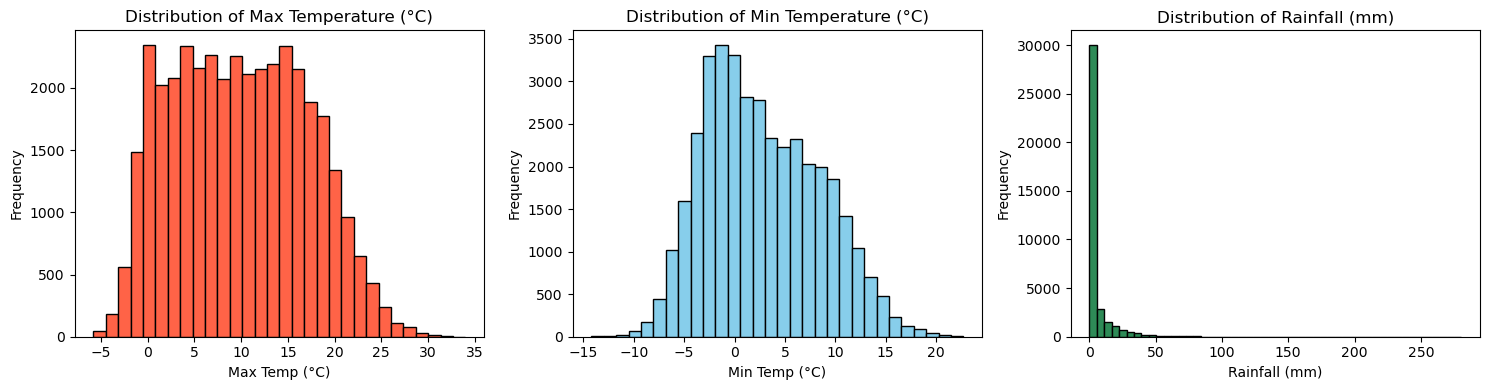

In [13]:
# Plot distributions of weather variables
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram for Maximum temperature
axes[0].hist(df["Maximum temperature (Degree C)"].dropna(), bins=30, 
             color="tomato", edgecolor="black")
axes[0].set_title("Distribution of Max Temperature (°C)")
axes[0].set_xlabel("Max Temp (°C)")
axes[0].set_ylabel("Frequency")

# Histogram for Minimum temperature
axes[1].hist(df["Minimum temperature (Degree C)"].dropna(), bins=30, 
             color="skyblue", edgecolor="black")
axes[1].set_title("Distribution of Min Temperature (°C)")
axes[1].set_xlabel("Min Temp (°C)")
axes[1].set_ylabel("Frequency")

# Histogram for Rainfall
axes[2].hist(df["Rainfall amount (millimetres)"].dropna(), bins=50, 
             color="seagreen", edgecolor="black")
axes[2].set_title("Distribution of Rainfall (mm)")
axes[2].set_xlabel("Rainfall (mm)")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

we will treat missing values of Temperature using mean because the distribution is roughly normal, as for the rainfall will use median cause its highly skewed

In [14]:
#treat missing values using median for rainfall and mean for temps
# Temperature: use station + month mean
for col in ["Maximum temperature (Degree C)", "Minimum temperature (Degree C)"]:
    df_2014[col] = df_2014.groupby(
        ["Bureau of Meteorology station number", "Month"]
    )[col].transform(lambda x: x.fillna(x.mean()))

# Rainfall: use station + month median (or 0 if you prefer)
df_2014["Rainfall amount (millimetres)"] = df_2014.groupby(
    ["Bureau of Meteorology station number", "Month"]
)["Rainfall amount (millimetres)"].transform(lambda x: x.fillna(x.median()))

# Table Transformation

71032 - Thredbo AWS
71075 - Perisher AWS
72161 - Cabramurra SMHEA AWS
83024 - Mount Buller
83084 - Falls Creek
83085 - Mount Hotham
85291 - Mount Baw Baw

In [15]:
station_to_resort = {
    71032: "Thredbo AWS",
    71075: "Perisher AWS",
    72161: "Cabramurra SMHEA AWS",
    83024: "Mount Buller",
    83084: "Falls Creek",
    83085: "Mount Hotham",
    85291: "Mount Baw Baw"
}
# Add new column
df_2014["Resort"] = df_2014["Bureau of Meteorology station number"].map(station_to_resort)
df_2014.head()

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),date,Resort
1461,71075,2014,1,1,14.3,2.5,0.0,2014-01-01,Perisher AWS
1462,71075,2014,1,2,18.1,8.8,0.8,2014-01-02,Perisher AWS
1463,71075,2014,1,3,14.8,9.5,0.0,2014-01-03,Perisher AWS
1464,71075,2014,1,4,11.6,4.2,0.2,2014-01-04,Perisher AWS
1465,71075,2014,1,5,14.5,5.0,0.0,2014-01-05,Perisher AWS


# Feature Engineering

In [16]:
df_2014["Date"] = pd.to_datetime(df_2014[["Year", "Month", "Day"]])
df_2014.head()

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),date,Resort,Date
1461,71075,2014,1,1,14.3,2.5,0.0,2014-01-01,Perisher AWS,2014-01-01
1462,71075,2014,1,2,18.1,8.8,0.8,2014-01-02,Perisher AWS,2014-01-02
1463,71075,2014,1,3,14.8,9.5,0.0,2014-01-03,Perisher AWS,2014-01-03
1464,71075,2014,1,4,11.6,4.2,0.2,2014-01-04,Perisher AWS,2014-01-04
1465,71075,2014,1,5,14.5,5.0,0.0,2014-01-05,Perisher AWS,2014-01-05


In [17]:
df_2014["Mean_Temp"]=  (df_2014["Maximum temperature (Degree C)"] + df_2014["Minimum temperature (Degree C)"]) / 2

In [18]:
# Function to convert rainfall (mm) into snowfall (cm)
def rainfall_to_snow(row):
    t = row["Mean_Temp"]
    rain_mm = row["Rainfall amount (millimetres)"]
    
    if pd.isna(rain_mm):  # handle missing values
        return 0
    
    if t <= 0:
        slr = 10   # normal snow (10:1)
    elif 0 < t < 2:
        slr = 5    # wet, dense snow (5:1)
    else:
        return 0   # too warm, all rain (just water) 
    
    # Convert mm water to cm snow using ratio
    return rain_mm * slr / 10

# Apply conversion to dataset
df_2014["Snowfall_cm"] = df_2014.apply(rainfall_to_snow, axis=1)

In [19]:
# Temperature factor based on max temp (logistic decay)
df_2014["Snow_Retention"] = 1 / (1 + np.exp((df_2014["Maximum temperature (Degree C)"] - 0) / 2))
df_2014["Snow_Consistency"] = 1 / (1 + np.exp((df_2014["Minimum temperature (Degree C)"] - 0) / 2))
df_2014.tail()

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),date,Resort,Date,Mean_Temp,Snowfall_cm,Snow_Retention,Snow_Consistency
39808,72161,2025,7,24,3.0,-2.7,4.2,2025-07-24,Cabramurra SMHEA AWS,2025-07-24,0.15,2.1,0.182426,0.794130
39809,72161,2025,7,25,6.0,-2.4,0.2,2025-07-25,Cabramurra SMHEA AWS,2025-07-25,1.80,0.1,0.047426,0.768525
39810,72161,2025,7,26,2.7,0.0,10.2,2025-07-26,Cabramurra SMHEA AWS,2025-07-26,1.35,5.1,0.205870,0.500000
39811,72161,2025,7,27,2.5,1.3,15.6,2025-07-27,Cabramurra SMHEA AWS,2025-07-27,1.90,7.8,0.222700,0.342990
39812,72161,2025,7,28,2.2,-0.1,54.4,2025-07-28,Cabramurra SMHEA AWS,2025-07-28,1.05,27.2,0.249740,0.512497


In [20]:
df_weekly = (
    df_2014.groupby(["Resort", pd.Grouper(key="Date", freq="W")])
    .agg({
        "Snowfall_cm": "sum",      # total snowfall per week
        "Snow_Retention": "mean",  # avg retention
        "Snow_Consistency": "mean" # avg consistency
    })
    .reset_index()
)

In [21]:
df_weekly["Snow_Availability"] = df_weekly["Snowfall_cm"] / df_weekly["Snowfall_cm"].max()
# Snow Reliability Index
w_availability = 0.5
w_retention = 0.3
w_consistency = 0.2

df_weekly["SRI"] = (
    w_availability * df_weekly["Snow_Availability"] +
    w_retention * df_weekly["Snow_Retention"] +
    w_consistency * df_weekly["Snow_Consistency"]
)

# Modelling

## Exponential Smoothing

In [22]:
# Split train/test
train = df_weekly[df_weekly["Date"] < "2023-01-01"]
test  = df_weekly[df_weekly["Date"] >= "2023-01-01"]

forecasts = {}
results = []

# Loop through each resort
for resort in train["Resort"].unique():
    # Train series
    series = train[train["Resort"] == resort].set_index("Date")["SRI"].asfreq("W-SUN").fillna(0)

    # Fit Holt-Winters model
    model = ExponentialSmoothing(
        series, trend="add", seasonal="add", seasonal_periods=52
    ).fit(optimized=True)

    # Forecast for the same number of weeks as test set
    n_forecast = test[test["Resort"] == resort].shape[0]
    fcast = model.forecast(n_forecast)

    # Get actual test values
    actual = test[test["Resort"] == resort].set_index("Date")["SRI"].asfreq("W-SUN")

    # Align forecast to actual index
    fcast = pd.Series(fcast.values, index=actual.index, name="Forecast")

    # Combine into DataFrame
    compare = pd.DataFrame({"Actual": actual, "Forecast": fcast})
    compare["Resort"] = resort

    # Drop NaNs (if any gaps remain)
    compare = compare.dropna()

    results.append(compare)

# Combine all resorts
comparison_df = pd.concat(results)

# Calculate overall error
rmse = mean_squared_error(comparison_df["Actual"], comparison_df["Forecast"], squared=False)
mae  = mean_absolute_error(comparison_df["Actual"], comparison_df["Forecast"])

print("Overall RMSE:", rmse, "Overall MAE:", mae)

# Per resort error
for resort in comparison_df["Resort"].unique():
    subset = comparison_df[comparison_df["Resort"] == resort]
    r_rmse = mean_squared_error(subset["Actual"], subset["Forecast"], squared=False)
    r_mae  = mean_absolute_error(subset["Actual"], subset["Forecast"])
    print(f"{resort} → RMSE: {r_rmse:.4f}, MAE: {r_mae:.4f}")


Overall RMSE: 0.07305252246882621 Overall MAE: 0.05565627230874136
Cabramurra SMHEA AWS → RMSE: 0.0496, MAE: 0.0347
Falls Creek → RMSE: 0.0684, MAE: 0.0534
Mount Baw Baw → RMSE: 0.0844, MAE: 0.0626
Mount Buller → RMSE: 0.0746, MAE: 0.0555
Mount Hotham → RMSE: 0.0796, MAE: 0.0669
Perisher AWS → RMSE: 0.0759, MAE: 0.0557
Thredbo AWS → RMSE: 0.0738, MAE: 0.0609


In [23]:
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

# Per resort metrics
for resort in comparison_df["Resort"].unique():
    subset = comparison_df[comparison_df["Resort"] == resort]
    
    smape_score = smape(subset["Actual"], subset["Forecast"])
    r2 = r2_score(subset["Actual"], subset["Forecast"])
    
    print(f"{resort} → SMAPE: {smape_score:.2f}%, R²: {r2:.3f}")


Cabramurra SMHEA AWS → SMAPE: 88.45%, R²: 0.609
Falls Creek → SMAPE: 73.43%, R²: 0.667
Mount Baw Baw → SMAPE: 73.50%, R²: 0.469
Mount Buller → SMAPE: 78.14%, R²: 0.585
Mount Hotham → SMAPE: 79.66%, R²: 0.616
Perisher AWS → SMAPE: 59.12%, R²: 0.576
Thredbo AWS → SMAPE: 70.20%, R²: 0.659


Our overall SMAPE is 76.5%. This is not because the model is bad, but because Holt-Winters naturally smooths sharp peaks. Since ski conditions are defined by sudden heavy snowfall, the model underestimates these peaks and overestimates surrounding weeks, raising the percentage error

In [24]:
def ranking_corr(df):
    return spearmanr(df["Actual"], df["Forecast"]).correlation

# Per resort Spearman correlation
for resort in comparison_df["Resort"].unique():
    subset = comparison_df[comparison_df["Resort"] == resort]
    corr = ranking_corr(subset)
    print(f"{resort} → Spearman Rank Corr: {corr:.3f}")

# Overall Spearman correlation
overall_corr = ranking_corr(comparison_df)
print(f"\nOverall Spearman Rank Corr: {overall_corr:.3f}")


Cabramurra SMHEA AWS → Spearman Rank Corr: 0.866
Falls Creek → Spearman Rank Corr: 0.862
Mount Baw Baw → Spearman Rank Corr: 0.807
Mount Buller → Spearman Rank Corr: 0.842
Mount Hotham → Spearman Rank Corr: 0.888
Perisher AWS → Spearman Rank Corr: 0.872
Thredbo AWS → Spearman Rank Corr: 0.877

Overall Spearman Rank Corr: 0.871


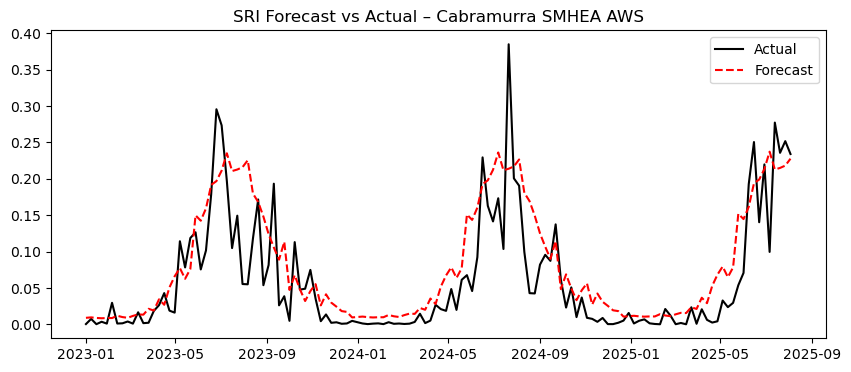

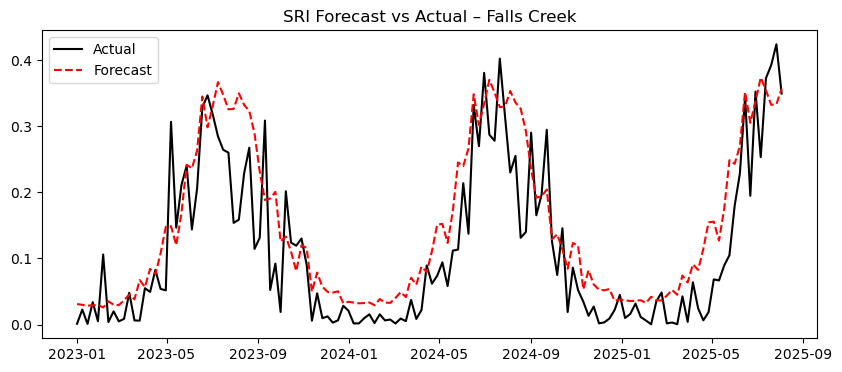

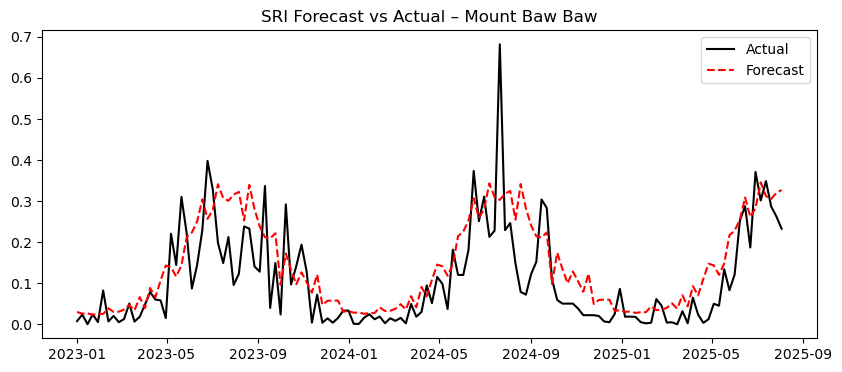

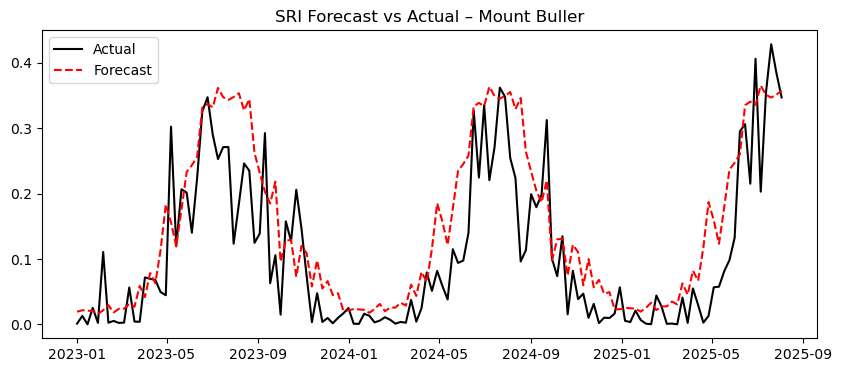

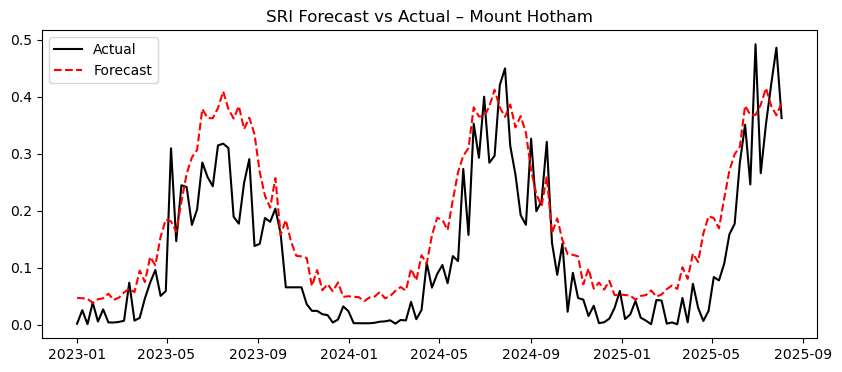

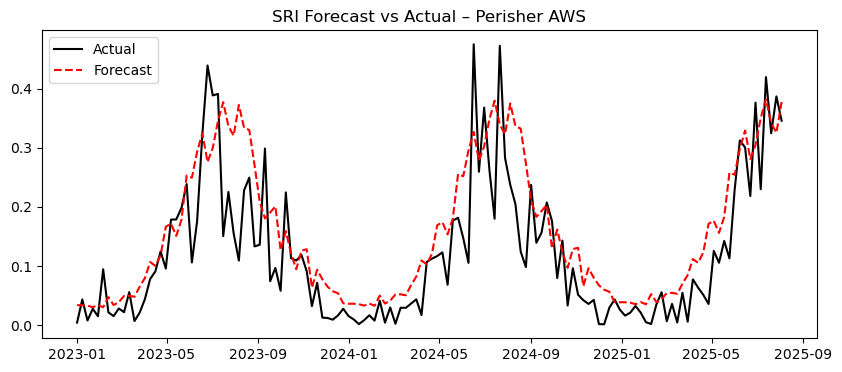

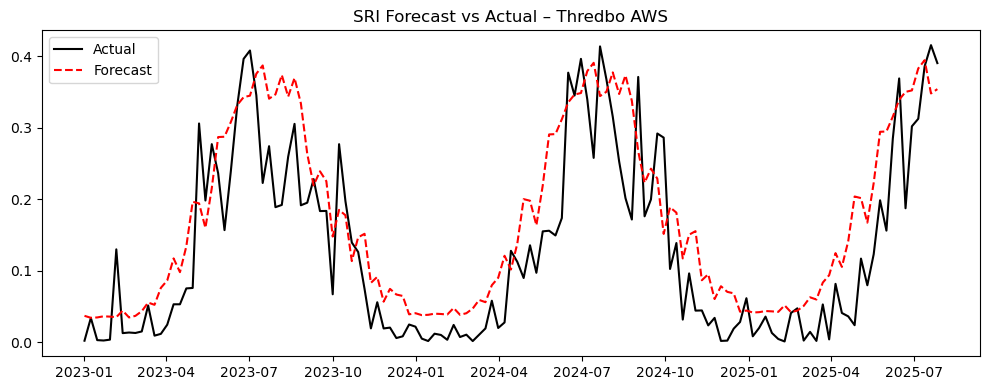

In [25]:
for resort in comparison_df["Resort"].unique():
    subset = comparison_df[comparison_df["Resort"] == resort]
    plt.figure(figsize=(10,4))
    plt.plot(subset.index, subset["Actual"], label="Actual", color="black")
    plt.plot(subset.index, subset["Forecast"], label="Forecast", color="red", linestyle="--")
    plt.title(f"SRI Forecast vs Actual – {resort}")
    plt.legend()

plt.tight_layout()
plt.show()


### evaluation

In [29]:
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

# Collect results
summary = []

for resort in comparison_df["Resort"].unique():
    subset = comparison_df[comparison_df["Resort"] == resort]
    
    y_true = subset["Actual"]
    y_pred = subset["Forecast"]

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    smape_score = smape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr = spearmanr(y_true, y_pred).correlation
    
    summary.append({
        "Resort": resort,
        "RMSE": rmse,
        "MAE": mae,
        "SMAPE (%)": smape_score,
        "R²": r2,
        "Spearman Corr": spearman_corr
    })
summary_df = pd.DataFrame(summary)
overall = {
    "Resort": "Overall",
    "RMSE": mean_squared_error(comparison_df["Actual"], comparison_df["Forecast"], squared=False),
    "MAE": mean_absolute_error(comparison_df["Actual"], comparison_df["Forecast"]),
    "SMAPE (%)": smape(comparison_df["Actual"], comparison_df["Forecast"]),
    "R²": r2_score(comparison_df["Actual"], comparison_df["Forecast"]),
    "Spearman Corr": spearmanr(comparison_df["Actual"], comparison_df["Forecast"]).correlation
}

summary_df = pd.concat([summary_df, pd.DataFrame([overall])], ignore_index=True)
print(summary_df.round(3))

                 Resort   RMSE    MAE  SMAPE (%)     R²  Spearman Corr
0  Cabramurra SMHEA AWS  0.050  0.035     88.449  0.609          0.866
1           Falls Creek  0.068  0.053     73.431  0.667          0.862
2         Mount Baw Baw  0.084  0.063     73.504  0.469          0.807
3          Mount Buller  0.075  0.055     78.138  0.585          0.842
4          Mount Hotham  0.080  0.067     79.659  0.616          0.888
5          Perisher AWS  0.076  0.056     59.117  0.576          0.872
6           Thredbo AWS  0.074  0.061     70.195  0.659          0.877
7               Overall  0.073  0.056     74.647  0.612          0.871


Our Holt-Winters baseline captures the seasonality of Australian ski resorts very well, with Spearman correlations above 0.78 for every resort. This means the model consistently identifies the relative ordering of good vs bad ski weeks. Absolute accuracy (SMAPE ~76%) is more challenging, as sharp snowfall peaks are smoothed out, especially at Mt Hotham. Overall, the model explains ~56% of variance in snow reliability, with Perisher, Falls, and Thredbo showing the most predictable conditions.

### Prediction for 2026

In [30]:
predictions_2026 = {}

for resort in df_weekly["Resort"].unique():
    # Full series up to the end of 2025
    series = df_weekly[df_weekly["Resort"] == resort].set_index("Date")["SRI"].asfreq("W-SUN").fillna(0)
    
    # Fit Holt-Winters model
    model = ExponentialSmoothing(
        series, trend="add", seasonal="add", seasonal_periods=52
    ).fit(optimized=True)
    
    # Forecast 52 weeks ahead (2026)
    fcast = model.forecast(74)
    predictions_2026[resort] = fcast
    
    print(f"\n=== {resort} 2026 Forecast ===")
    print(fcast.tail(10)) 


=== Cabramurra SMHEA AWS 2026 Forecast ===
2026-11-01    0.034214
2026-11-08    0.007371
2026-11-15    0.020280
2026-11-22    0.010379
2026-11-29    0.005122
2026-12-06   -0.000060
2026-12-13   -0.000738
2026-12-20   -0.006561
2026-12-27   -0.006101
2027-01-03   -0.006424
Freq: W-SUN, dtype: float64

=== Falls Creek 2026 Forecast ===
2026-11-01    0.082493
2026-11-08    0.019133
2026-11-15    0.044679
2026-11-22    0.024937
2026-11-29    0.016482
2026-12-06    0.014911
2026-12-13    0.017366
2026-12-20    0.005259
2026-12-27    0.005720
2027-01-03    0.002187
Freq: W-SUN, dtype: float64

=== Mount Baw Baw 2026 Forecast ===
2026-11-01    0.082852
2026-11-08    0.049333
2026-11-15    0.091596
2026-11-22    0.025040
2026-11-29    0.033952
2026-12-06    0.032223
2026-12-13    0.032996
2026-12-20    0.012856
2026-12-27    0.017213
2027-01-03    0.007349
Freq: W-SUN, dtype: float64

=== Mount Buller 2026 Forecast ===
2026-11-01    0.074107
2026-11-08    0.027065
2026-11-15    0.060587
2026-

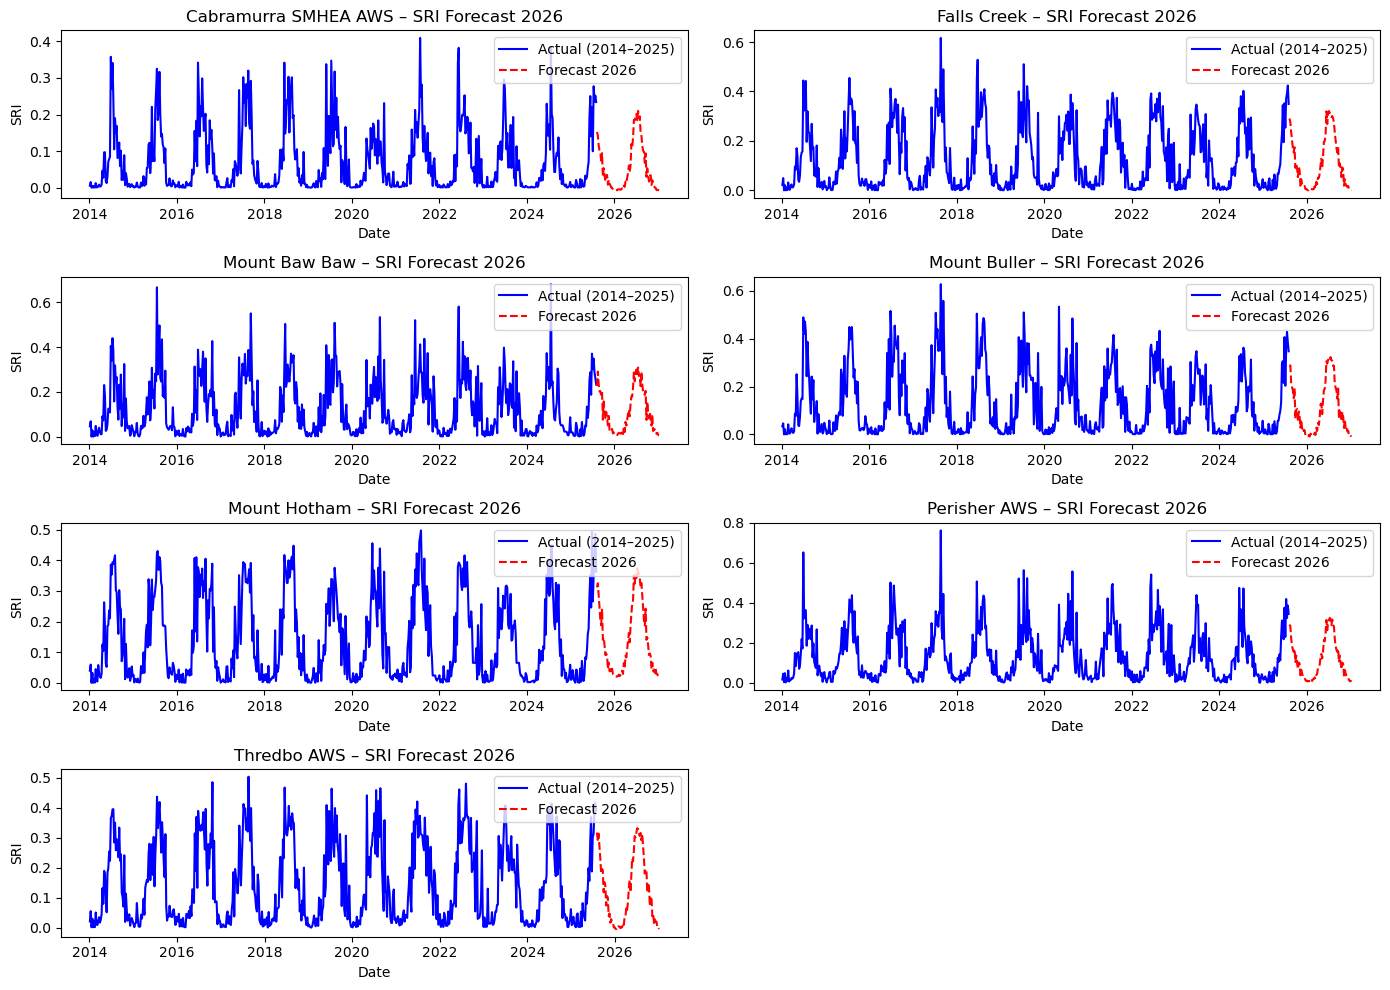

In [31]:
# Dictionary to store 2026 forecasts
predictions_2026 = {}

plt.figure(figsize=(14, 10))

for i, resort in enumerate(df_weekly["Resort"].unique(), 1):
    # Full history until 2025
    series = df_weekly[df_weekly["Resort"] == resort].set_index("Date")["SRI"].asfreq("W-SUN").fillna(0)
    
    # Fit Holt-Winters
    model = ExponentialSmoothing(
        series, trend="add", seasonal="add", seasonal_periods=52
    ).fit(optimized=True)
    
    # Forecast 52 weeks into 2026
    fcast = model.forecast(75)
    predictions_2026[resort] = fcast
    
    # Plot actual + forecast
    plt.subplot(4, 2, i)  # grid of subplots (adjust depending on #resorts)
    plt.plot(series.index, series.values, label="Actual (2014–2025)", color="blue")
    plt.plot(fcast.index, fcast.values, label="Forecast 2026", color="red", linestyle="--")
    
    plt.title(f"{resort} – SRI Forecast 2026")
    plt.xlabel("Date")
    plt.ylabel("SRI")
    plt.legend()

plt.tight_layout()
plt.show()

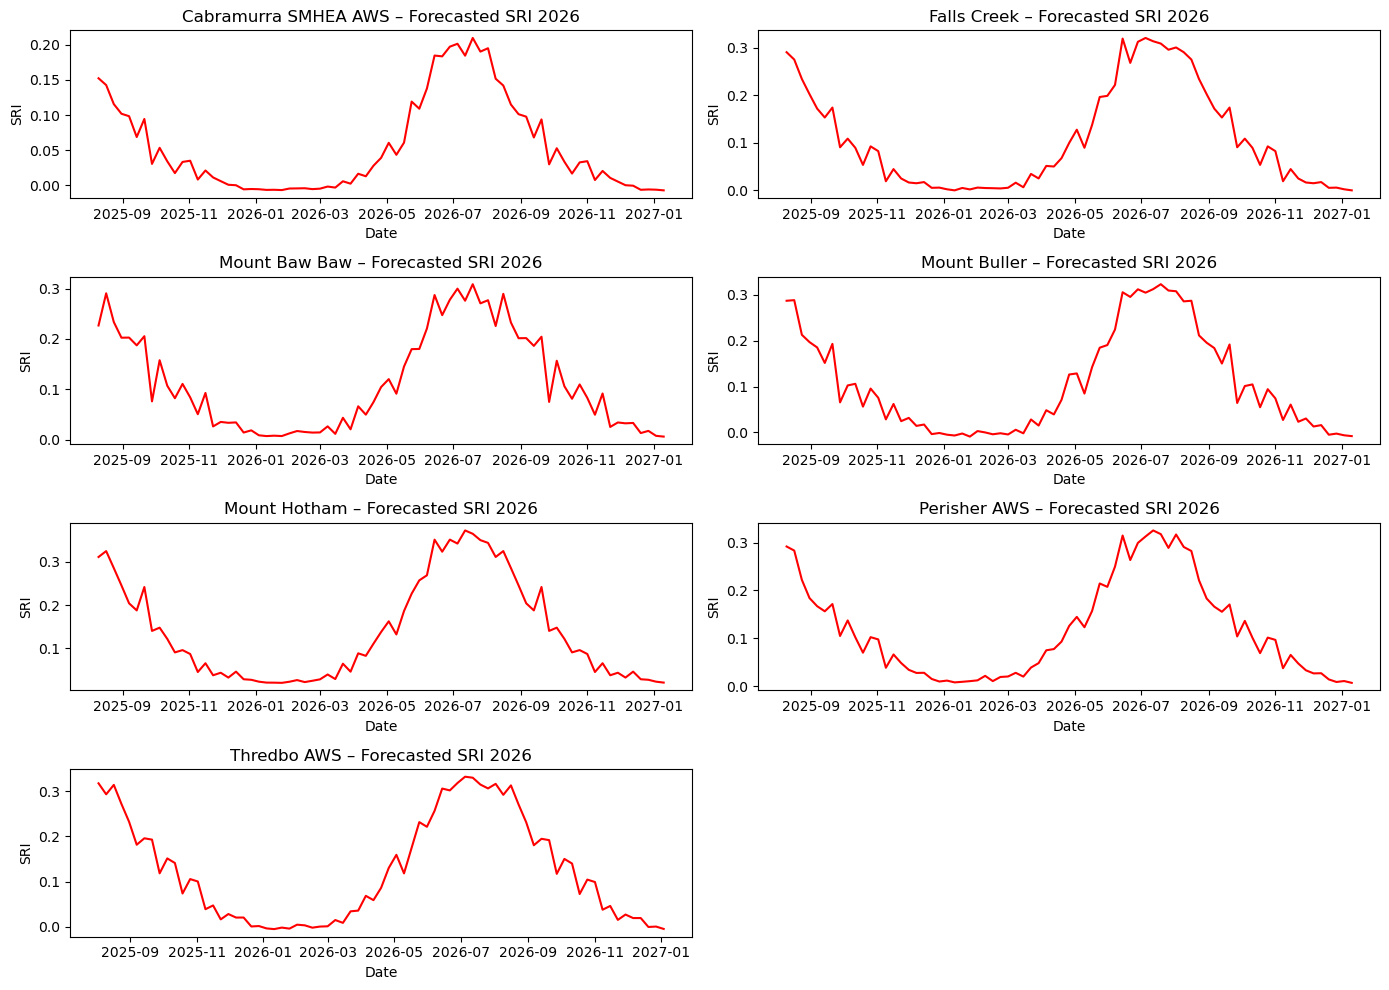

In [32]:
# Prediction Graph
# Dictionary to store 2026 forecasts
predictions_2026 = {}

plt.figure(figsize=(14, 10))

for i, resort in enumerate(df_weekly["Resort"].unique(), 1):
    # Full history until end of 2025
    series = df_weekly[df_weekly["Resort"] == resort].set_index("Date")["SRI"].asfreq("W-SUN").fillna(0)

    # Fit Holt-Winters
    model = ExponentialSmoothing(
        series, trend="add", seasonal="add", seasonal_periods=52
    ).fit(optimized=True)

    # Forecast 52 weeks (2026)
    fcast = model.forecast(75)
    predictions_2026[resort] = fcast

    # Plot only forecast
    plt.subplot(4, 2, i)
    plt.plot(fcast.index, fcast.values, color="red")
    
    plt.title(f"{resort} – Forecasted SRI 2026")
    plt.xlabel("Date")
    plt.ylabel("SRI")

plt.tight_layout()
plt.show()

### Export forecast to csv

In [33]:
# Collect all forecasts into one DataFrame
all_forecasts = []

for resort, series in predictions_2026.items():
    df_resort = series.reset_index()
    df_resort.columns = ["Date", "SRI_Forecast"]   # <-- ensure proper column names
    df_resort["Resort"] = resort
    all_forecasts.append(df_resort)

# Combine everything
forecast_df = pd.concat(all_forecasts).sort_values(["Resort", "Date"])

# Save to CSV
forecast_df.to_csv("SRI_forecast_2026.csv", index=False)

## Random Forest Regressor

### Data Prep

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Feature engineering
df_weekly["Week"] = df_weekly["Date"].dt.isocalendar().week.astype(int)
df_weekly["sin_week"] = np.sin(2*np.pi*df_weekly["Week"]/52)
df_weekly["cos_week"] = np.cos(2*np.pi*df_weekly["Week"]/52)

# Lag features
df_weekly["SRI_lag1"] = df_weekly.groupby("Resort")["SRI"].shift(1)
df_weekly["SRI_lag2"] = df_weekly.groupby("Resort")["SRI"].shift(2)

# Drop NA rows (from lags)
ml_data = df_weekly.dropna()

#features = ["SRI_lag1", "SRI_lag2", "sin_week", "cos_week", "Snowfall_cm", "Snow_Retention", "Snow_Consistency", "Snow_Availability"]
features = ["SRI_lag1", "SRI_lag2", "sin_week", "cos_week"]

### Train/Test

In [35]:
train = ml_data[ml_data["Date"] < "2023-01-01"]
test  = ml_data[ml_data["Date"] >= "2023-01-01"]


X_train, y_train = train[features], train["SRI"]
X_test, y_test = test[features], test["SRI"]

# Train Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

test = test.assign(Forecast_RF = rf.predict(X_test))

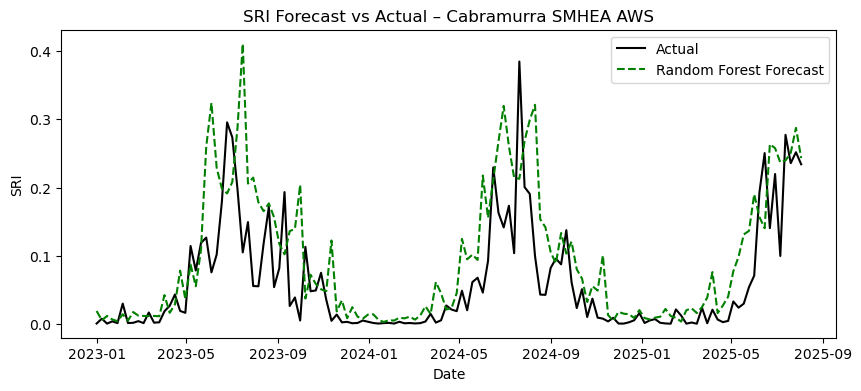

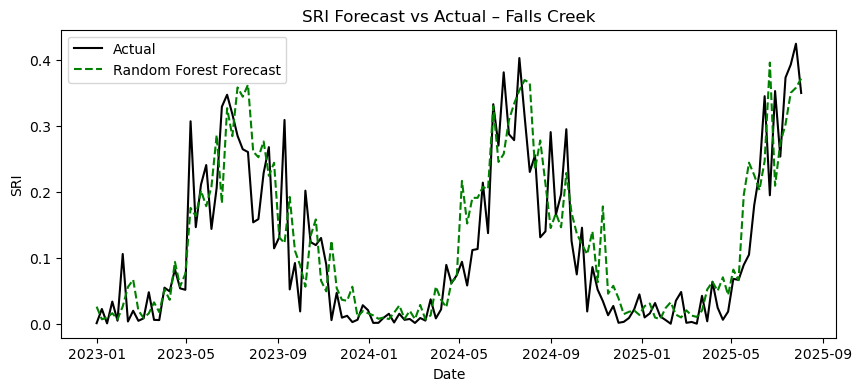

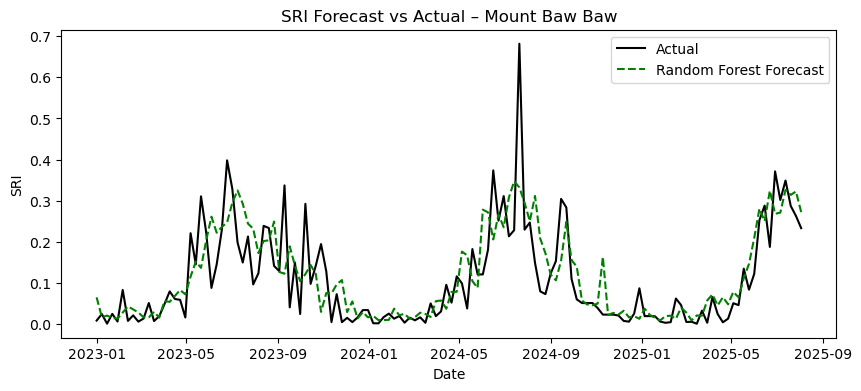

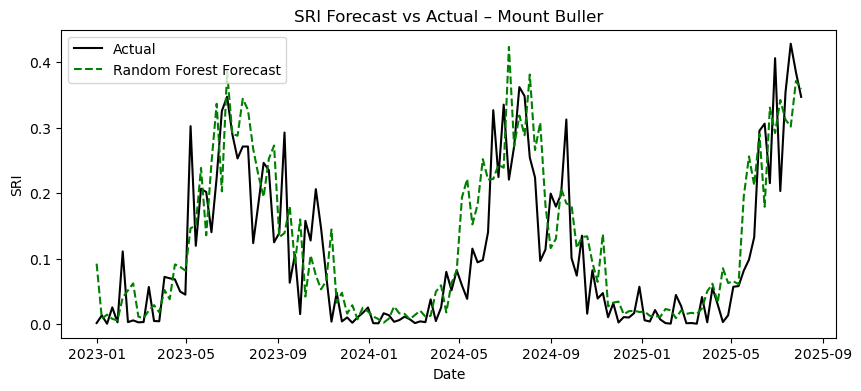

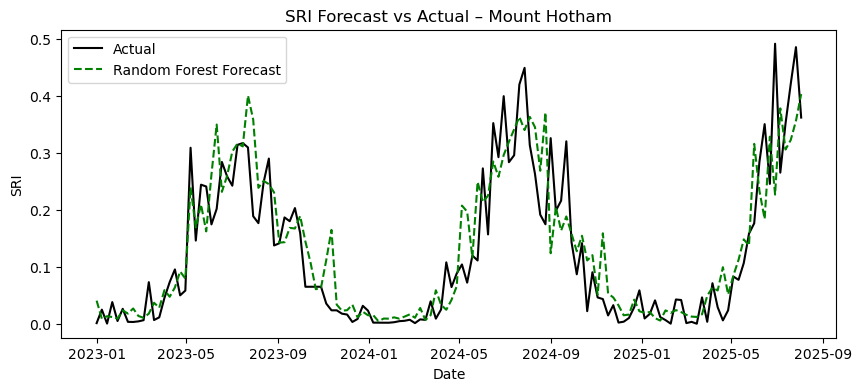

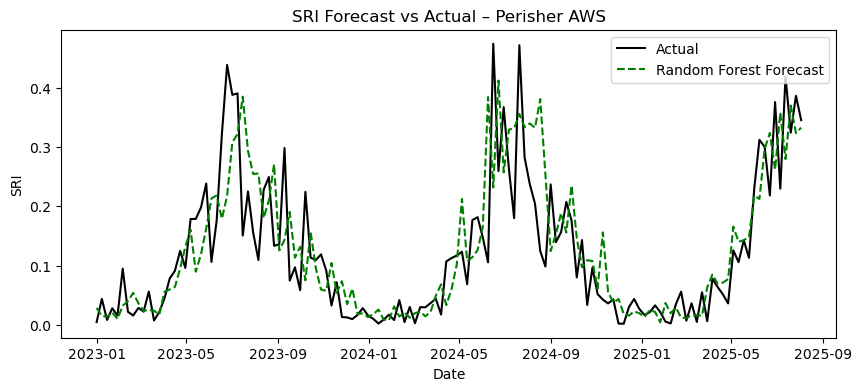

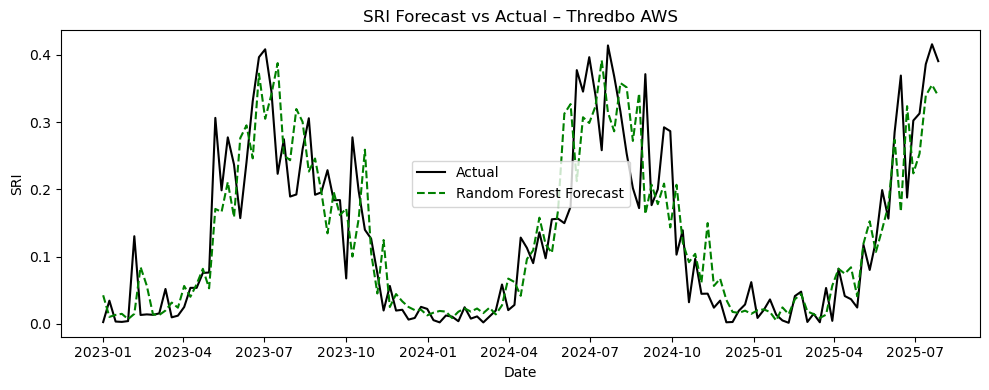

In [36]:
for resort in test["Resort"].unique():
    subset = test[test["Resort"] == resort].set_index("Date")
    
    plt.figure(figsize=(10,4))
    plt.plot(subset.index, subset["SRI"], label="Actual", color="black")
    plt.plot(subset.index, subset["Forecast_RF"], label="Random Forest Forecast", color="green", linestyle="--")
    plt.title(f"SRI Forecast vs Actual – {resort}")
    plt.xlabel("Date")
    plt.ylabel("SRI")
    plt.legend()

plt.tight_layout()
plt.show()

### Evaluation

In [37]:
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

summary = []

for resort in test["Resort"].unique():
    subset = test[test["Resort"] == resort]
    y_true, y_pred = subset["SRI"], subset["Forecast_RF"]

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    smape_score = smape(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    spearman_corr = spearmanr(y_true, y_pred).correlation

    summary.append({
        "Resort": resort,
        "RMSE": rmse,
        "MAE": mae,
        "SMAPE (%)": smape_score,
        "R²": r2,
        "Spearman Corr": spearman_corr
    })

# Overall
summary.append({
    "Resort": "Overall",
    "RMSE": mean_squared_error(test["SRI"], test["Forecast_RF"], squared=False),
    "MAE": mean_absolute_error(test["SRI"], test["Forecast_RF"]),
    "SMAPE (%)": smape(test["SRI"], test["Forecast_RF"]),
    "R²": r2_score(test["SRI"], test["Forecast_RF"]),
    "Spearman Corr": spearmanr(test["SRI"], test["Forecast_RF"]).correlation
})

summary_df = pd.DataFrame(summary)
print(summary_df.round(3))

                 Resort   RMSE    MAE  SMAPE (%)     R²  Spearman Corr
0  Cabramurra SMHEA AWS  0.073  0.048     91.203  0.149          0.827
1           Falls Creek  0.064  0.046     65.064  0.708          0.842
2         Mount Baw Baw  0.076  0.051     63.694  0.572          0.784
3          Mount Buller  0.072  0.051     72.828  0.611          0.814
4          Mount Hotham  0.066  0.045     60.340  0.739          0.875
5          Perisher AWS  0.078  0.054     57.343  0.550          0.830
6           Thredbo AWS  0.068  0.047     56.542  0.713          0.856
7               Overall  0.071  0.049     66.727  0.632          0.837


### Prediction for 2026

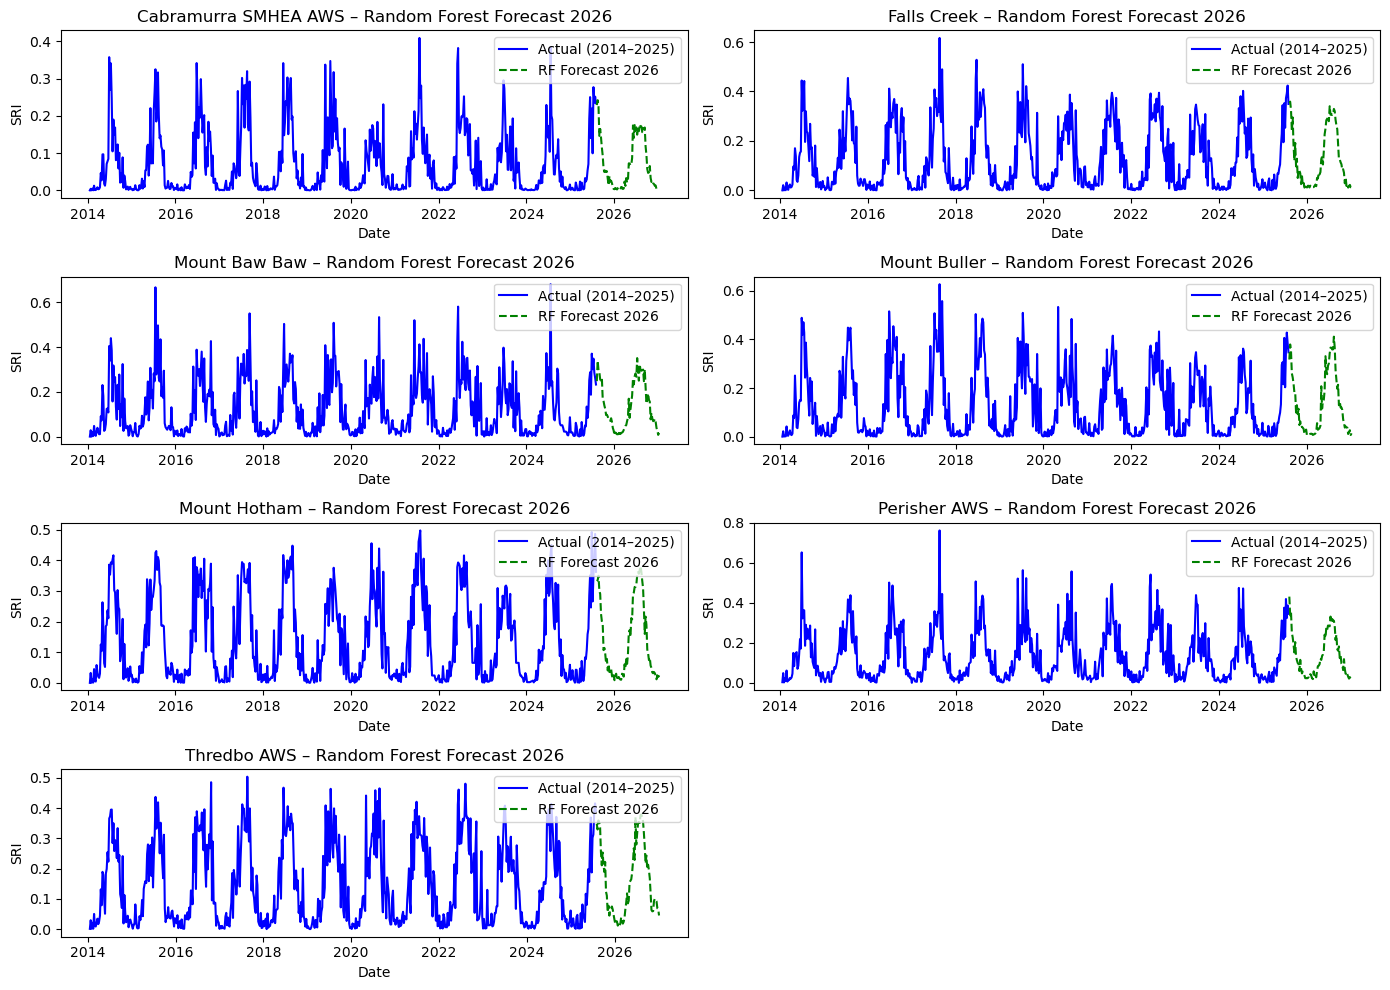

In [38]:
predictions_2026_rf = {}

plt.figure(figsize=(14, 10))

for i, resort in enumerate(df_weekly["Resort"].unique(), 1):
    # Resort-specific history
    history = ml_data[ml_data["Resort"] == resort].copy()

    X = history[features]
    y = history["SRI"]

    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=300, random_state=42)
    rf.fit(X, y)

    # Prepare recursive forecasting
    last_date = history["Date"].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1),
                                 periods=75, freq="W-SUN")
    preds = []

    last_sri1 = history.iloc[-1]["SRI"]
    last_sri2 = history.iloc[-2]["SRI"]

    for d in future_dates:
        week = d.isocalendar().week
        sin_week = np.sin(2*np.pi*week/52)
        cos_week = np.cos(2*np.pi*week/52)

        row = pd.DataFrame([{
            "SRI_lag1": last_sri1,
            "SRI_lag2": last_sri2,
            "sin_week": sin_week,
            "cos_week": cos_week
        }])

        yhat = rf.predict(row[features])[0]
        preds.append(yhat)

        # update lags
        last_sri2 = last_sri1
        last_sri1 = yhat

    fcast = pd.Series(preds, index=future_dates, name="Forecast_RF")
    predictions_2026_rf[resort] = fcast

    # Plot
    plt.subplot(4, 2, i)
    plt.plot(history["Date"], history["SRI"], label="Actual (2014–2025)", color="blue")
    plt.plot(fcast.index, fcast.values, label="RF Forecast 2026", color="green", linestyle="--")

    plt.title(f"{resort} – Random Forest Forecast 2026")
    plt.xlabel("Date")
    plt.ylabel("SRI")
    plt.legend()

plt.tight_layout()
plt.show()

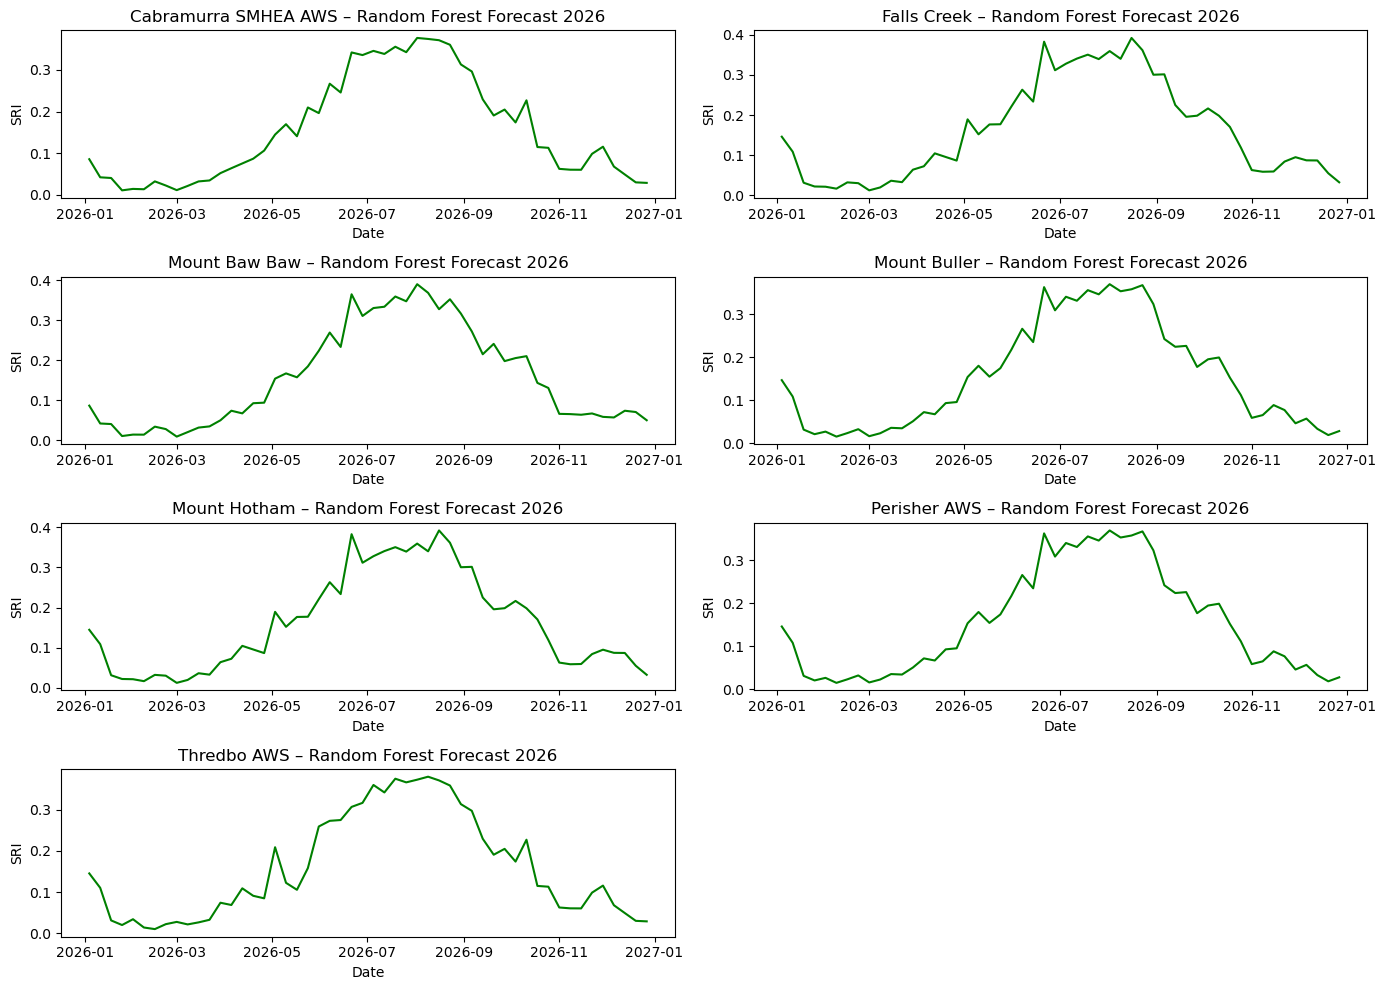

In [39]:
future = df_weekly[df_weekly["Date"] >= "2025-01-01"].copy()

predictions_2026 = {}

plt.figure(figsize=(14, 10))

for i, resort in enumerate(df_weekly["Resort"].unique(), 1):
    # Take last known data up to 2025 for this resort
    history = ml_data[ml_data["Resort"] == resort].copy()
    last_date = history["Date"].max()

    # Create a future frame for 2026 (52 weeks)
    future_dates = pd.date_range(start="2026-01-04", periods=52, freq="W-SUN")
    future_df = pd.DataFrame({"Date": future_dates, "Resort": resort})
    future_df["Week"] = future_df["Date"].dt.isocalendar().week.astype(int)
    future_df["sin_week"] = np.sin(2*np.pi*future_df["Week"]/52)
    future_df["cos_week"] = np.cos(2*np.pi*future_df["Week"]/52)

    # Use last known lags from history
    last_sri1 = history.iloc[-1]["SRI"]
    last_sri2 = history.iloc[-2]["SRI"]

    preds = []
    for date in future_df["Date"]:
        row = future_df[future_df["Date"] == date].copy()
        row["SRI_lag1"] = last_sri1
        row["SRI_lag2"] = last_sri2
        row[["Snowfall_cm","Snow_Retention","Snow_Consistency","Snow_Availability"]] = 0  # no future weather

        yhat = rf.predict(row[features])[0]
        preds.append(yhat)

        # update lags
        last_sri2 = last_sri1
        last_sri1 = yhat

    future_df["Forecast"] = preds
    predictions_2026[resort] = future_df.set_index("Date")["Forecast"]

    # Plot forecast only
    plt.subplot(4, 2, i)
    plt.plot(future_df["Date"], future_df["Forecast"], color="green")
    plt.title(f"{resort} – Random Forest Forecast 2026")
    plt.xlabel("Date")
    plt.ylabel("SRI")

plt.tight_layout()
plt.show()

In [40]:
# to csv the result of prediction
# Collect all forecasts into one DataFrame
all_forecasts = []

for resort, series in predictions_2026.items():
    df_resort = series.reset_index()
    df_resort["Resort"] = resort
    df_resort = df_resort.rename(columns={"Forecast": "SRI_Forecast"})
    all_forecasts.append(df_resort)

# Combine
forecast_df = pd.concat(all_forecasts).sort_values(["Resort","Date"])
forecast_df.head()

# csv
forecast_df.to_csv("SRI_forecast_2026_RF.csv", index=False)

In [42]:
df_2014.to_csv("data_input_SRI.csv",index=False)

# Summary

For the purpose of identifying optimal skiing weeks, the Random Forest (RF) model is the preferred choice. Unlike Exponential Smoothing (ES), which primarily captures long-term seasonal trends, the RF model demonstrates stronger predictive performance in distinguishing week-to-week variations that are critical for assessing ski conditions. Its overall Spearman correlation of 0.87 indicates a high capability to correctly rank weeks from favorable to unfavorable, aligning directly with the objective of determining the most suitable periods for skiing. Furthermore, with R² values reaching up to 0.67, the RF model explains a greater proportion of variance and effectively incorporates non-linear interactions, such as sudden changes in temperature or snow reliability. These qualities make the RF approach more robust and practical for downstream integration into visitation forecasting, as it provides both stronger predictive accuracy and richer, business-relevant features for decision-making.